# Kernel Tutorial

This tutorial is a simplify version of: https://pennylane.ai/qml/demos/tutorial_kernels_module

<table class="nt-notebook-buttons" align="center">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/JeremieGince/Learning_SVM/blob/main/tutorial_kernels.ipynb"><img src="https://github.com/NeuroTorch/NeuroTorch/blob/main/images/colab_logo_32px.png?raw=true" width=32px height=32px  />Run in Google Colab</a>
</td>
  <td>
    <a target="_blank" href="https://github.com/JeremieGince/Learning_SVM/blob/main/tutorial_kernels.ipynb"><img src="https://github.githubassets.com/images/modules/logos_page/GitHub-Mark.png" width=32px height=32px />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/JeremieGince/Learning_SVM/blob/main/tutorial_kernels.ipynb"><img src="https://github.com/NeuroTorch/NeuroTorch/blob/main/images/download_logo_32px.png?raw=true" width=32px height=32px />Download notebook</a>
  </td>
</table>

## Setup

You can now install the dependencies by running the following commands:

In [1]:
%%capture
#@title Install dependencies {display-mode: "form"}

RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

if RunningInCOLAB:
    !git clone https://github.com/JeremieGince/Learning_SVM.git
    %cd Learning_SVM/

!pip install -r requirements.txt

After setting up the virtual environment, we will need to import the necessary packages.


In [2]:
import time
import os

import matplotlib.pyplot as plt
from pennylane import numpy as np
import numpy as snp
import pennylane as qml
import pandas as pd
import psutil
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

if RunningInCOLAB:
    from Learning_SVM.visualization import Visualizer
else:
    from visualization import Visualizer


np.random.seed(42)

In [3]:
%matplotlib inline

## Dataset

In the next cell, we will load the dataset. By uncommenting the appropriate line, you can choose between the breast cancer, iris, or synthetic dataset.

In [4]:
# dataset = datasets.load_breast_cancer(as_frame=True)
# dataset = datasets.load_iris(as_frame=True)
dataset = datasets.make_classification(
    n_samples=64,
    n_features=4,
    n_classes=2,
    n_clusters_per_class=2,
    n_informative=4,
    n_redundant=0,
    random_state=0,
)

In [5]:
if isinstance(dataset, tuple):
    X, y = dataset
elif isinstance(dataset, dict):
    X = dataset["data"]
    y = dataset["target"]
elif isinstance(dataset, pd.DataFrame):
    X = dataset.data
    y = dataset.target
else:
    raise ValueError(f"Unknown dataset type: {type(dataset)}")

n_features = X.shape[-1]

## Preprocessing

In [6]:
X = StandardScaler().fit_transform(X)
# X = MinMaxScaler(feature_range=(0, 1)).fit_transform(X)
# y = MinMaxScaler(feature_range=(-1, 1)).fit_transform(y.reshape(-1, 1)).reshape(-1).astype(int)
print(f"(N Samples, N features): {X.shape}")
print(f"Labels: {set(np.unique(y))}")
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
print(f"N train samples: {x_train.shape[0]}, N test samples: {x_test.shape[0]}")

(N Samples, N features): (64, 4)
Labels: {tensor(0, requires_grad=True), tensor(1, requires_grad=True)}
N train samples: 57, N test samples: 7


# The Kernel

The kernel $K(v, z) = \langle{\psi(v), \psi(z)}\rangle$ provides the advantage that we can often find an explicit formula for the kernel $K$ that makes it superfluous to actually perform the (potentially expensive) embedding $\psi(\cdot)$. Here is an example with the data $v = (v_0, v_1)$ and $z = (z_0,  z_1)$:
$$
\begin{align*}
    \psi(v) &= (v_0^2, \sqrt{2} v_0 v_1, v_1^2)^T \\
    K(v, z) &= (v_0^2, \sqrt{2} v_0 v_1, v_1^2) \cdot (z_0^2 \sqrt{2} z_0 z_1 z_1^2)^T  \\
    &= v_0^2z_0^2 + 2v_0 v_1z_0 z_1  + v_1^2z_1^2 \\
    \implies K(v, z) &= \langle v, z \rangle^2
\end{align*}
$$

Let's say we have a parameterized quantum circuit $U_\Theta(x)$ with the parameters $\Theta$. We can write the embedding function as
$$
\begin{align*}
    |\psi(x)\rangle &= U_\Theta(x)|0\rangle,
\end{align*}
$$
which provide the following kernel:
$$
\begin{align*}
    K(v, z) &= |\langle \psi(v) | \psi(z) \rangle|^2 \\
    &= |\langle 0 |U^\dagger_\Theta(v)U_\Theta(z) | 0 \rangle|^2.
\end{align*}
$$


# Defining the Quantum Kernel



In [7]:
def layer(x, params, wires, i0=0, inc=1):
    """Building block of the embedding ansatz"""
    i = i0
    for j, wire in enumerate(wires):
        qml.Hadamard(wires=[wire])
        qml.RZ(x[i % x.shape[0]], wires=[wire])
        i += inc
        qml.RY(params[0, j], wires=[wire])

    qml.broadcast(unitary=qml.CRZ, pattern="ring", wires=wires, parameters=params[1])

In [8]:
def ansatz(x, params, wires):
    """The embedding ansatz"""
    for j, layer_params in enumerate(params):
        layer(x, layer_params, wires, i0=j * len(wires))


adjoint_ansatz = qml.adjoint(ansatz)


def random_params(num_wires, num_layers):
    """Generate random variational parameters in the shape for the ansatz."""
    return np.random.uniform(0, 2 * np.pi, (num_layers, n_features, num_wires), requires_grad=True)

Together with the ansatz we only need a device to run the quantum
circuit on. For the purpose of this tutorial we will use PennyLane\'s
`default.qubit` device with 5 wires in analytic mode.


In [9]:
dev = qml.device("lightning.qubit", wires=5, shots=None)
wires = dev.wires.tolist()

Let us now define the quantum circuit that realizes the kernel. We will
compute the overlap of the quantum states by first applying the
embedding of the first datapoint and then the adjoint of the embedding
of the second datapoint. We finally extract the probabilities of
observing each basis state.


In [10]:
@qml.qnode(dev, interface="autograd")
def kernel_circuit(x1, x2, params):
    ansatz(x1, params, wires=wires)
    adjoint_ansatz(x2, params, wires=wires)
    projector = np.zeros((2 ** len(wires), 2 ** len(wires)))
    projector[0, 0] = 1
    return qml.expval(qml.Hermitian(projector, wires=wires))
    # return qml.probs(wires=wires)

The kernel function itself is now obtained by looking at the probability
of observing the all-zero state at the end of the kernel circuit --
because of the ordering in `qml.probs`, this is the first entry:


In [11]:
def kernel(x1, x2, params):
    return kernel_circuit(x1, x2, params)
    # return kernel_circuit(x1, x2, params)[0]

::: {.note}
::: {.title}
Note
:::

An alternative way to set up the kernel circuit in PennyLane would be to
use the observable type
[Projector](https://pennylane.readthedocs.io/en/latest/code/api/pennylane.Projector.html).
This is shown in the [demo on kernel-based training of quantum
models](https://pennylane.ai/qml/demos/tutorial_kernel_based_training.html),
where you will also find more background information on the kernel
circuit structure itself.
:::

Before focusing on the kernel values we have to provide values for the
variational parameters. At this point we fix the number of layers in the
ansatz circuit to $6$.


In [12]:
init_params = random_params(num_wires=len(wires), num_layers=6)

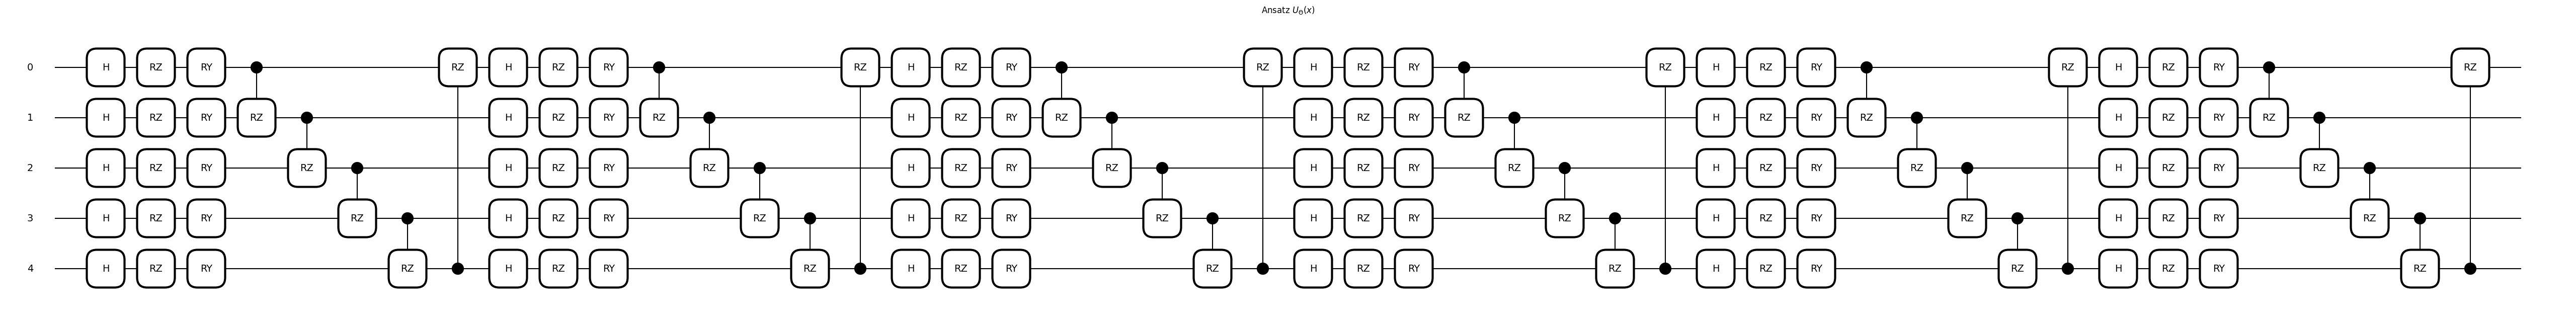

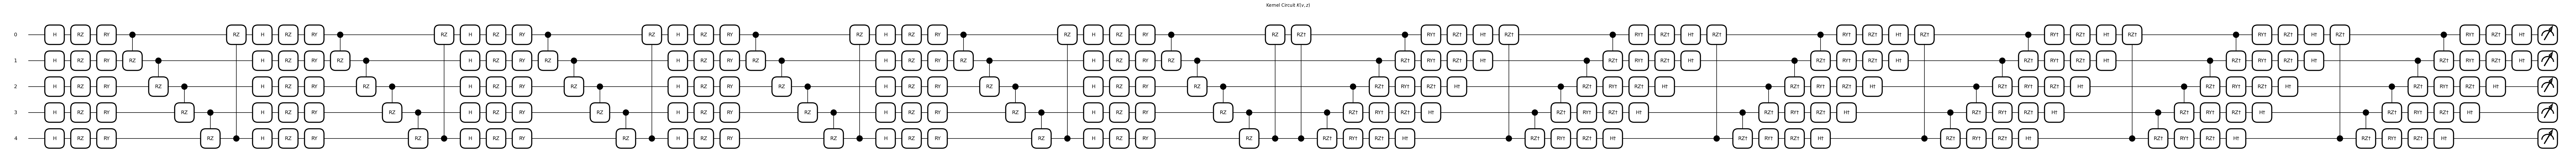

In [13]:
# fig, axes = plt.subplots(2, 1, tight_layout=True, figsize=(14, 10), sharex="all", sharey="all")
# axes = snp.ravel(snp.asarray([axes]))

# fig, ax = qml.draw_mpl(ansatz, style="black_white", decimals=None)(2*np.ones((n_features, )), np.ones((1, n_features, len(wires))), wires)

fig0, ax0 = qml.draw_mpl(ansatz)(2*np.ones((n_features, )), init_params, wires)
ax0.set_title("Ansatz $U_\Theta(x)$")

fig1, ax1 = qml.draw_mpl(kernel_circuit)(np.ones((n_features, )), np.ones((n_features, )), init_params)
ax1.set_title("Kernel Circuit $K(v, z)$")

os.makedirs("figures", exist_ok=True)
fig0.savefig("figures/quantum_circuit_U.pdf")
fig1.savefig("figures/quantum_circuit_K.pdf")

Now we can have a look at the kernel value between the first and the
second datapoint:


In [14]:
kernel_value = kernel(X[0], X[1], init_params)
print(f"The kernel value between the first and second datapoint is {kernel_value:.3f}")

The kernel value between the first and second datapoint is 0.014


The mutual kernel values between all elements of the dataset form the
*kernel matrix*. We can inspect it via the
`qml.kernels.square_kernel_matrix` method, which makes use of symmetry
of the kernel,
$k(\boldsymbol{x}_i,\boldsymbol{x}_j) = k(\boldsymbol{x}_j, \boldsymbol{x}_i)$.
In addition, the option `assume_normalized_kernel=True` ensures that we
do not calculate the entries between the same datapoints, as we know
them to be 1 for our noiseless simulation. Overall this means that we
compute $\frac{1}{2}(N^2-N)$ kernel values for $N$ datapoints. To
include the variational parameters, we construct a `lambda` function
that fixes them to the values we sampled above.


In [15]:
init_kernel = lambda x1, x2: kernel(x1, x2, init_params)
K_init = qml.kernels.square_kernel_matrix(x_train, init_kernel, assume_normalized_kernel=True)

with np.printoptions(precision=3, suppress=True):
    print(K_init)

[[1.    0.007 0.012 ... 0.027 0.026 0.025]
 [0.007 1.    0.046 ... 0.062 0.008 0.051]
 [0.012 0.046 1.    ... 0.047 0.066 0.034]
 ...
 [0.027 0.062 0.047 ... 1.    0.454 0.047]
 [0.026 0.008 0.066 ... 0.454 1.    0.292]
 [0.025 0.051 0.034 ... 0.047 0.292 1.   ]]


In [16]:
svm = SVC(kernel=lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, init_kernel))

In [17]:
fit_start_time = time.time()
svm.fit(x_train, y_train)
fit_end_time = time.time()
fit_time = fit_end_time - fit_start_time
print(f"{fit_time = :.5f} [s]")

fit_time = 65.10114 [s]


In [18]:
accuracy_init = svm.score(x_test, y_test)
accuracy_init_train = svm.score(x_train, y_train)
print(f"Accuracy of the kernel with random parameters: Test: {accuracy_init*100:.3f}%, Train: {accuracy_init_train*100:.3f}%")

Accuracy of the kernel with random parameters: Test: 85.714%, Train: 98.246%


Test accuracy: 85.7143%, Train accuracy: 98.2456%, fit_time = 65.10114 [s], plot_time = 1178.89021 [s]


C:\Users\gince\AppData\Local\Temp\ipykernel_22368\3108961343.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


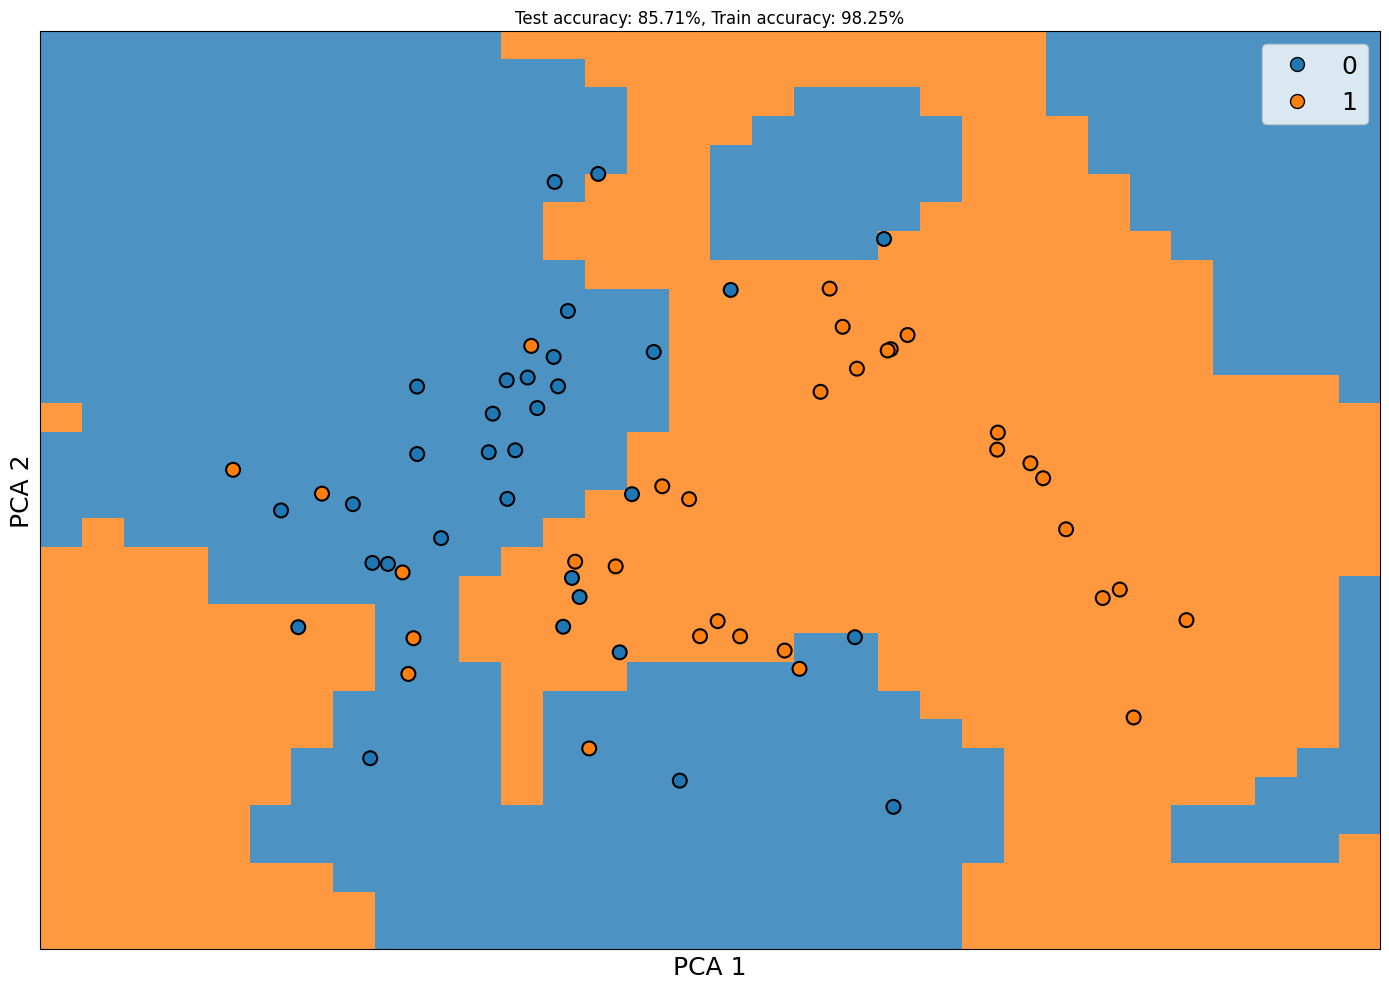

In [19]:
plot_start_time = time.time()
fig, ax = Visualizer.plot_2d_decision_boundaries(
    model=svm,
    X=X, y=y,
    check_estimators=False,
    n_pts=int(2*len(X)**1.5),
    title=f"Decision boundaries in the reduced space.",
    legend_labels=getattr(dataset, "target_names", None),
    interpolation="nearest",
)
ax.set_title(f"Test accuracy: {accuracy_init * 100:.2f}%, Train accuracy: {accuracy_init_train*100:.2f}%")
plot_end_time = time.time()
plot_time = plot_end_time - plot_start_time
print(f"Test accuracy: {accuracy_init * 100 :.4f}%, Train accuracy: {accuracy_init_train*100:.4f}%, {fit_time = :.5f} [s], {plot_time = :.5f} [s]")

os.makedirs("figures", exist_ok=True)
fig.savefig("figures/2d_decision_boundaries.pdf", dpi=300)
fig.show()

We see the outer points in the dataset can be correctly classified, but
we still struggle with the inner circle. But remember we have a circuit
with many free parameters! It is reasonable to believe we can give
values to those variational parameters which improve the overall
accuracy of our SVC.

Training the Quantum Embedding Kernel
=====================================

To be able to train the Quantum Embedding Kernel we need some measure of
how well it fits the dataset in question. Performing an exhaustive
search in parameter space is not a good solution because it is very
resource intensive, and since the accuracy is a discrete quantity we
would not be able to detect small improvements.

We can, however, resort to a more specialized measure, the
*kernel-target alignment*. The kernel-target alignment compares the
similarity predicted by the quantum kernel to the actual labels of the
training data. It is based on *kernel alignment*, a similiarity measure
between two kernels with given kernel matrices $K_1$ and $K_2$:

$$\operatorname{KA}(K_1, K_2) = \frac{\operatorname{Tr}(K_1 K_2)}{\sqrt{\operatorname{Tr}(K_1^2)\operatorname{Tr}(K_2^2)}}.$$

::: {.note}
::: {.title}
Note
:::

Seen from a more theoretical side, $\operatorname{KA}$ is nothing else
than the cosine of the angle between the kernel matrices $K_1$ and $K_2$
if we see them as vectors in the space of matrices with the
Hilbert-Schmidt (or Frobenius) scalar product
$\langle A, B \rangle = \operatorname{Tr}(A^T B)$. This reinforces the
geometric picture of how this measure relates to objects, namely two
kernels, being aligned in a vector space.
:::

The training data enters the picture by defining an *ideal* kernel
function that expresses the original labelling in the vector
$\boldsymbol{y}$ by assigning to two datapoints the product of the
corresponding labels:

$$k_{\boldsymbol{y}}(\boldsymbol{x}_i, \boldsymbol{x}_j) = y_i y_j.$$

The assigned kernel is thus $+1$ if both datapoints lie in the same
class and $-1$ otherwise and its kernel matrix is simply given by the
outer product $\boldsymbol{y}\boldsymbol{y}^T$. The kernel-target
alignment is then defined as the kernel alignment of the kernel matrix
$K$ generated by the quantum kernel and
$\boldsymbol{y}\boldsymbol{y}^T$:

$$\operatorname{KTA}_{\boldsymbol{y}}(K)
= \frac{\operatorname{Tr}(K \boldsymbol{y}\boldsymbol{y}^T)}{\sqrt{\operatorname{Tr}(K^2)\operatorname{Tr}((\boldsymbol{y}\boldsymbol{y}^T)^2)}}
= \frac{\boldsymbol{y}^T K \boldsymbol{y}}{\sqrt{\operatorname{Tr}(K^2)} N}$$

where $N$ is the number of elements in $\boldsymbol{y}$, that is the
number of datapoints in the dataset.

In summary, the kernel-target alignment effectively captures how well
the kernel you chose reproduces the actual similarities of the data. It
does have one drawback, however: having a high kernel-target alignment
is only a necessary but not a sufficient condition for a good
performance of the kernel. This means having good alignment is
guaranteed for good performance, but optimal alignment will not always
bring optimal training accuracy with it.

Let\'s now come back to the actual implementation. PennyLane\'s
`kernels` module allows you to easily evaluate the kernel target
alignment:


In [20]:
kta_init = qml.kernels.target_alignment(x_train, y_train, init_kernel, assume_normalized_kernel=True)

print(f"The kernel-target alignment for our dataset and random parameters is {kta_init*100:.3f}%")

The kernel-target alignment for our dataset and random parameters is 27.622%


Now let\'s code up an optimization loop and improve the kernel-target
alignment!

We will make use of regular gradient descent optimization. To speed up
the optimization we will not use the entire training set to compute
$\operatorname{KTA}$ but rather sample smaller subsets of the data at
each step, we choose $4$ datapoints at random. Remember that
PennyLane\'s built-in optimizer works to *minimize* the cost function
that is given to it, which is why we have to multiply the kernel target
alignment by $-1$ to actually *maximize* it in the process.

::: {.note}
::: {.title}
Note
:::

Currently, the function `qml.kernels.target_alignment` is not
differentiable yet, making it unfit for gradient descent optimization.
We therefore first define a differentiable version of this function.
:::


In [ ]:
def target_alignment(
    _X,
    Y,
    kernel,
    assume_normalized_kernel=False,
    rescale_class_labels=True,
    eps=1e-8,
):
    """Kernel-target alignment between kernel and labels."""

    K = qml.kernels.square_kernel_matrix(
        _X,
        kernel,
        assume_normalized_kernel=assume_normalized_kernel,
    )

    if rescale_class_labels:
        nplus = np.count_nonzero(np.array(Y) == 1)
        nminus = len(Y) - nplus
        _Y = np.array([y / (nplus + eps) if y == 1 else y / (nminus + eps) for y in Y])
    else:
        _Y = np.array(Y)

    T = np.outer(_Y, _Y)
    inner_product = np.sum(K * T)
    norm = np.sqrt(np.sum(K * K) * np.sum(T * T))
    inner_product = inner_product / (norm + eps)

    return inner_product


params = init_params
opt = qml.GradientDescentOptimizer(1e-1)

for i in range(500):
    # Choose subset of datapoints to compute the KTA on.
    subset = np.random.choice(list(range(len(x_train))), 4)
    # Define the cost function for optimization
    cost = lambda _params: -target_alignment(
        x_train[subset],
        y_train[subset],
        lambda x1, x2: kernel(x1, x2, _params),
        assume_normalized_kernel=True,
        rescale_class_labels=True,
    )
    # Optimization step
    params = opt.step(cost, params)

    # Report the alignment on the full dataset every 50 steps.
    if (i + 1) % 50 == 0:
        current_alignment = target_alignment(
            x_train[subset],
            y_train[subset],
            lambda x1, x2: kernel(x1, x2, params),
            assume_normalized_kernel=True,
            rescale_class_labels=True,
        )
        print(f"Step {i+1} - Alignment = {current_alignment:.3f}")

We want to assess the impact of training the parameters of the quantum
kernel. Thus, let\'s build a second support vector classifier with the
trained kernel:


In [ ]:
# First create a kernel with the trained parameter baked into it.
trained_kernel = lambda x1, x2: kernel(x1, x2, params)

# Second create a kernel matrix function using the trained kernel.
trained_kernel_matrix = lambda X1, X2: qml.kernels.kernel_matrix(X1, X2, trained_kernel)

# Note that SVC expects the kernel argument to be a kernel matrix function.
svm_trained = SVC(kernel=trained_kernel_matrix)

In [ ]:
fit_start_time = time.time()
svm_trained.fit(x_train, y_train)
fit_end_time = time.time()
fit_time = fit_end_time - fit_start_time
print(f"{fit_time = :.5f} [s]")

We expect to see an accuracy improvement vs. the SVM with random
parameters:


In [ ]:
accuracy_trained = svm_trained.score(x_test, y_test)
print(f"The accuracy of a kernel with trained parameters is {accuracy_trained:.3f}")

We have now achieved perfect classification! 🎆

Following on the results that SVM\'s have proven good generalisation
behavior, it will be interesting to inspect the decision boundaries of
our classifier:


In [ ]:
plot_start_time = time.time()
fig, ax = Visualizer.plot_2d_decision_boundaries(
    model=svm_trained,
    X=X, y=y,
    check_estimators=False,
    n_pts=100,
    title=f"Decision boundaries in the reduced space.",
    legend_labels=getattr(dataset, "target_names", None),
    # axis_name="RN",
    # fig=fig, ax=axes[i],
    interpolation="nearest",
)
ax.set_title(f"accuracy: {accuracy_trained * 100:.2f}%")
plot_end_time = time.time()
plot_time = plot_end_time - plot_start_time
print(f"test accuracy: {accuracy_trained * 100 :.4f}%, {fit_time = :.5f} [s], {plot_time = :.5f} [s]")
fig.show()